In [1]:
import os
import numpy as np
import pandas as pd
from gtfparse import read_gtf
from matplotlib import pylab as plt

In [2]:
root_path = os.path.abspath("./")

statistics_folder = os.path.join(root_path, "statistics/")
if(not os.path.exists(statistics_folder)):
    os.mkdir(statistics_folder)

figure_folder = os.path.join(root_path, "figures/")
if(not os.path.exists(figure_folder)):
    os.mkdir(figure_folder)
    
data_path = os.path.join(root_path, "gencode.v41.annotation.gtf.gz")



### 1. 读取数据

In [3]:
data = read_gtf(data_path)

/home/cuiyanfei/anaconda3/lib/python3.8/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home/cuiyanfei/anaconda3/lib/python3.8/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'hgnc_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


In [4]:
print(data.iloc[0])

seqname                                                   chr1
source                                                  HAVANA
feature                                                   gene
start                                                    11869
end                                                      14409
score                                                      NaN
strand                                                       +
frame                                                        0
gene_id                                      ENSG00000223972.5
gene_type                   transcribed_unprocessed_pseudogene
gene_name                                              DDX11L1
level                                                        2
hgnc_id                                             HGNC:37102
havana_gene                               OTTHUMG00000000961.2
transcript_id                                                 
transcript_type                                        

### 2. 计算染色体上的蛋白质编码基因

In [5]:
# 生成染色体编号
chr_num = ["chr%d"%(i) for i in range(1,23)]
chr_num.extend(["chrX", "chrY", "chrM"])

protein_coding_genes = dict()
for chr in chr_num:
    if(chr not in protein_coding_genes):
        protein_coding_genes[chr] = -1

# 计算每个染色体上的蛋白质编码基因
for chr in chr_num:
    chr_data = data[data["seqname"] == chr]
    chr_gene = chr_data[chr_data["feature"] == "gene"]
    chr_protein_gene = chr_gene[chr_gene["gene_type"] == "protein_coding"]
    protein_coding_genes[chr] = len(chr_protein_gene)



print(protein_coding_genes)

{'chr1': 2062, 'chr2': 1247, 'chr3': 1077, 'chr4': 754, 'chr5': 882, 'chr6': 1049, 'chr7': 930, 'chr8': 696, 'chr9': 774, 'chr10': 730, 'chr11': 1318, 'chr12': 1037, 'chr13': 322, 'chr14': 615, 'chr15': 600, 'chr16': 856, 'chr17': 1185, 'chr18': 266, 'chr19': 1474, 'chr20': 546, 'chr21': 219, 'chr22': 446, 'chrX': 856, 'chrY': 63, 'chrM': 13}


### 3. 计算相关的长度数据

In [6]:
def cal_gene_len(gene, ind):
    len = gene["end"][ind] - gene["start"][ind] + 1
    return len

def cal_dis(gene_data, chr_data):
    genes_len_list, exons_len_list, introns_len_list = [], [], []
    for i in gene_data.index:
        gene_len = cal_gene_len(chr_data, i)
        exon_len = 0
        if(chr_data["feature"][i + 1] == "transcript"):
            exon_end = chr_data["start"][i + 1]
            trains_len = cal_gene_len(chr_data, i + 1)
            i += 2
            while(chr_data["feature"][i] != "gene" and chr_data["feature"][i] != "transcript"):
                if(chr_data["feature"][i] == "exon"):
                    if(chr_data["start"][i] >= exon_end):
                        exon_len += cal_gene_len(chr_data, i)
                        exon_end = chr_data["end"][i]
                    else:
                        break
                i += 1
            genes_len_list.append(gene_len)
            exons_len_list.append(exon_len)
            introns_len_list.append(gene_len - exon_len)
    return genes_len_list, exons_len_list, introns_len_list           

In [7]:
chr_genes_len = []
chr_exons_len = []
chr_introns_len = []
for chr in chr_num:
    chr_data = data[data["seqname"] == chr]
    chr_genes = chr_data[chr_data["feature"] == "gene"]
    chr_protein_genes = chr_genes[chr_genes["gene_type"] == "protein_coding"]
    genes_len_list, exons_len_list, introns_len_list = cal_dis(chr_protein_genes, chr_data)
    chr_genes_len.append(genes_len_list)
    chr_exons_len.append(exons_len_list)
    chr_introns_len.append(introns_len_list)

### 4. 读取全部染色体的长度数据

|           |median           |mean             |max              |min              |
|---------- |---------------- |---------------- |---------------- |---------------- |
|genes      |27474.000000     |68894.653295     |2473539.000000   |39.000000        |
|exons      |598.000000       |1509.769396      |33681.000000     |3.000000         |
|introns    |26127.000000     |67384.883899     |2472710.000000   |0.000000         |


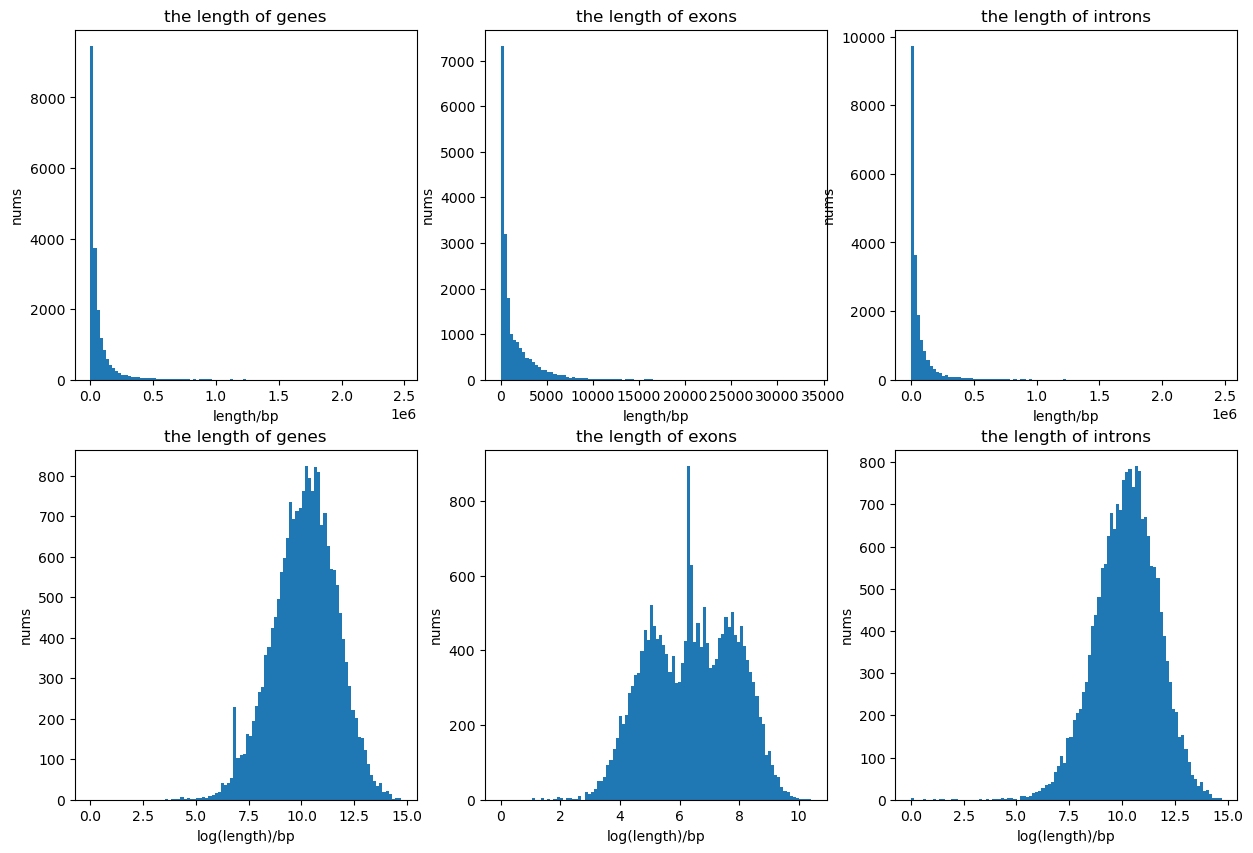

In [8]:
whole_genes_len = np.array(sum(chr_genes_len, []))
whole_exons_len = np.array(sum(chr_exons_len, []))
whole_introns_len = np.array(sum(chr_introns_len, []))

whole_genes_len_log = np.log(whole_genes_len + 1e-12)
whole_exons_len_log = np.log(whole_exons_len + 1e-12)
whole_introns_len_log = np.log(whole_introns_len + 1e-12)

print("|%-10s |%-16s |%-16s |%-16s |%-16s |"%("", "median", "mean", "max", "min"))
print("|%s |%s |%s |%s |%s |"%("-"*10, "-"*16, "-"*16, "-"*16, "-"*16))
print("|%-10s |%-16f |%-16f |%-16f |%-16f |"%("genes", np.median(whole_genes_len), np.mean(whole_genes_len), np.max(whole_genes_len), np.min(whole_genes_len)))
print("|%-10s |%-16f |%-16f |%-16f |%-16f |"%("exons", np.median(whole_exons_len), np.mean(whole_exons_len), np.max(whole_exons_len), np.min(whole_exons_len)))
print("|%-10s |%-16f |%-16f |%-16f |%-16f |"%("introns", np.median(whole_introns_len), np.mean(whole_introns_len), np.max(whole_introns_len), np.min(whole_introns_len)))


plt.figure(0, figsize=(15, 10))

plt.subplot(2,3,1)
plt.title("the length of genes")
plt.xlabel("length/bp")
plt.ylabel("nums")
plt.hist(whole_genes_len, 100, range=(0, whole_genes_len.max()))

plt.subplot(2,3,2)
plt.title("the length of exons")
plt.xlabel("length/bp")
plt.ylabel("nums")
plt.hist(whole_exons_len, 100, range=(0, whole_exons_len.max()))

plt.subplot(2,3,3)
if whole_introns_len.max() != 0:
    plt.title("the length of introns")
    plt.xlabel("length/bp")
    plt.ylabel("nums")
    plt.hist(whole_introns_len, 100, range=(0, whole_introns_len.max()))

plt.subplot(2,3,4)
plt.title("the length of genes")
plt.xlabel("log(length)/bp")
plt.ylabel("nums")
plt.hist(whole_genes_len_log, 100, range=(0, whole_genes_len_log.max()))

plt.subplot(2,3,5)
plt.title("the length of exons")
plt.xlabel("log(length)/bp")
plt.ylabel("nums")
plt.hist(whole_exons_len_log, 100, range=(0, whole_exons_len_log.max()))

plt.subplot(2,3,6)
if whole_introns_len.max() != 0:
    plt.title("the length of introns")
    plt.xlabel("log(length)/bp")
    plt.ylabel("nums")
    plt.hist(whole_introns_len_log, 100, range=(0, whole_introns_len_log.max()))
    
plt.savefig(os.path.join(figure_folder, "whole_chr.png"))
plt.show()


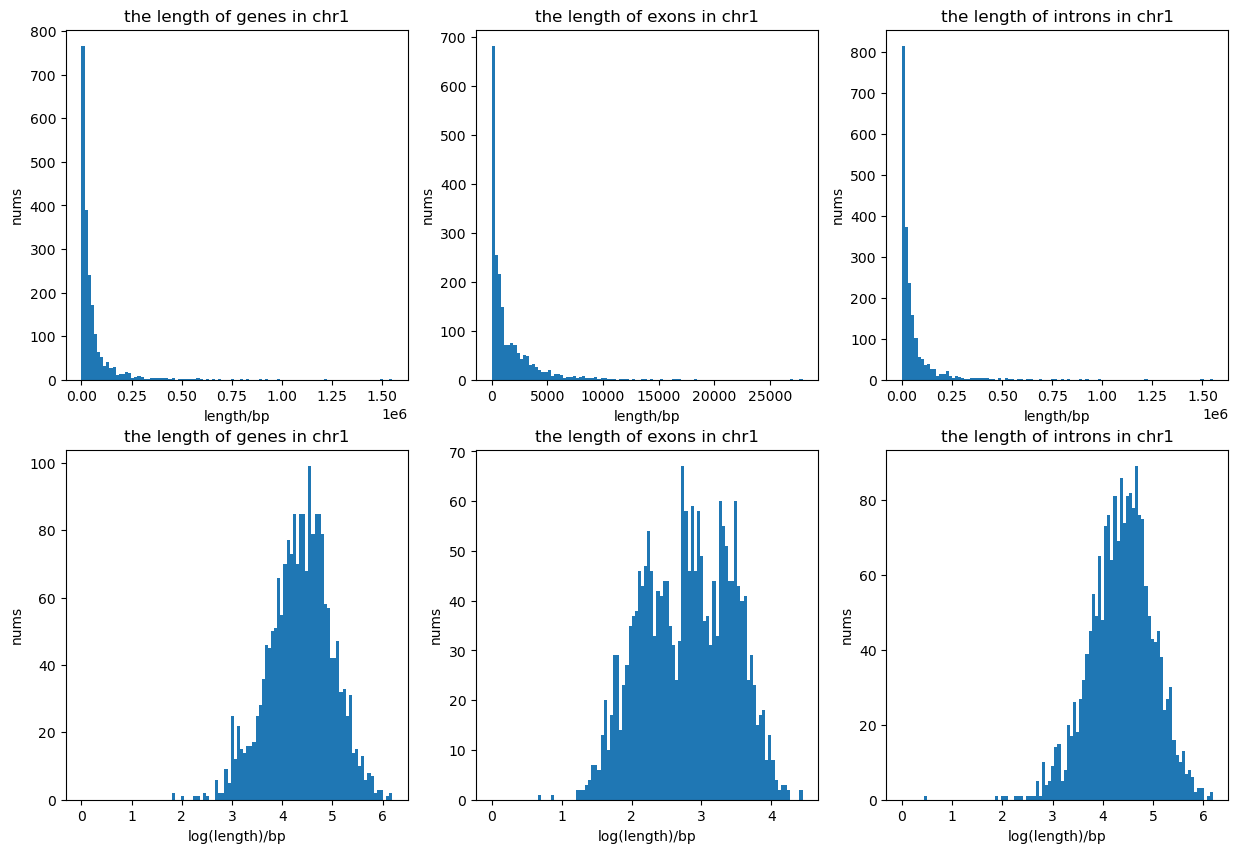

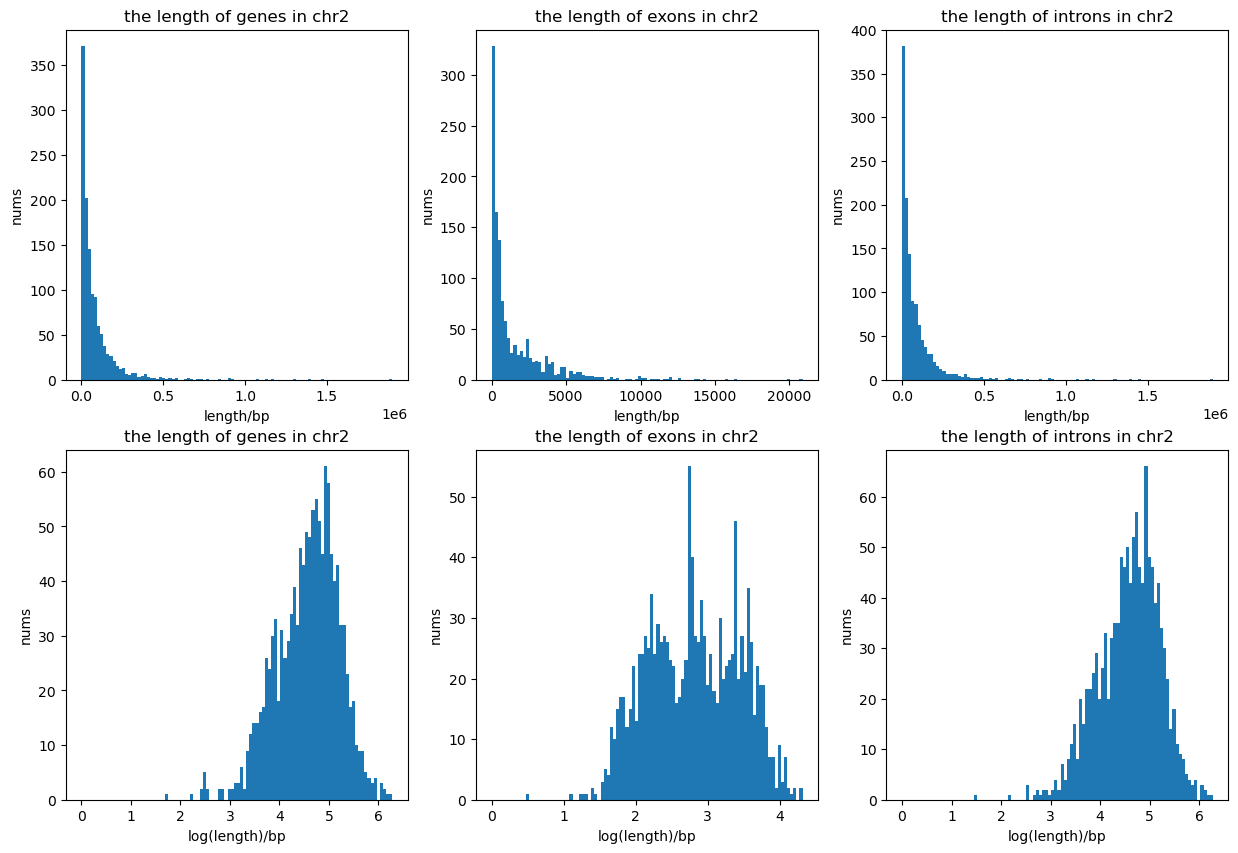

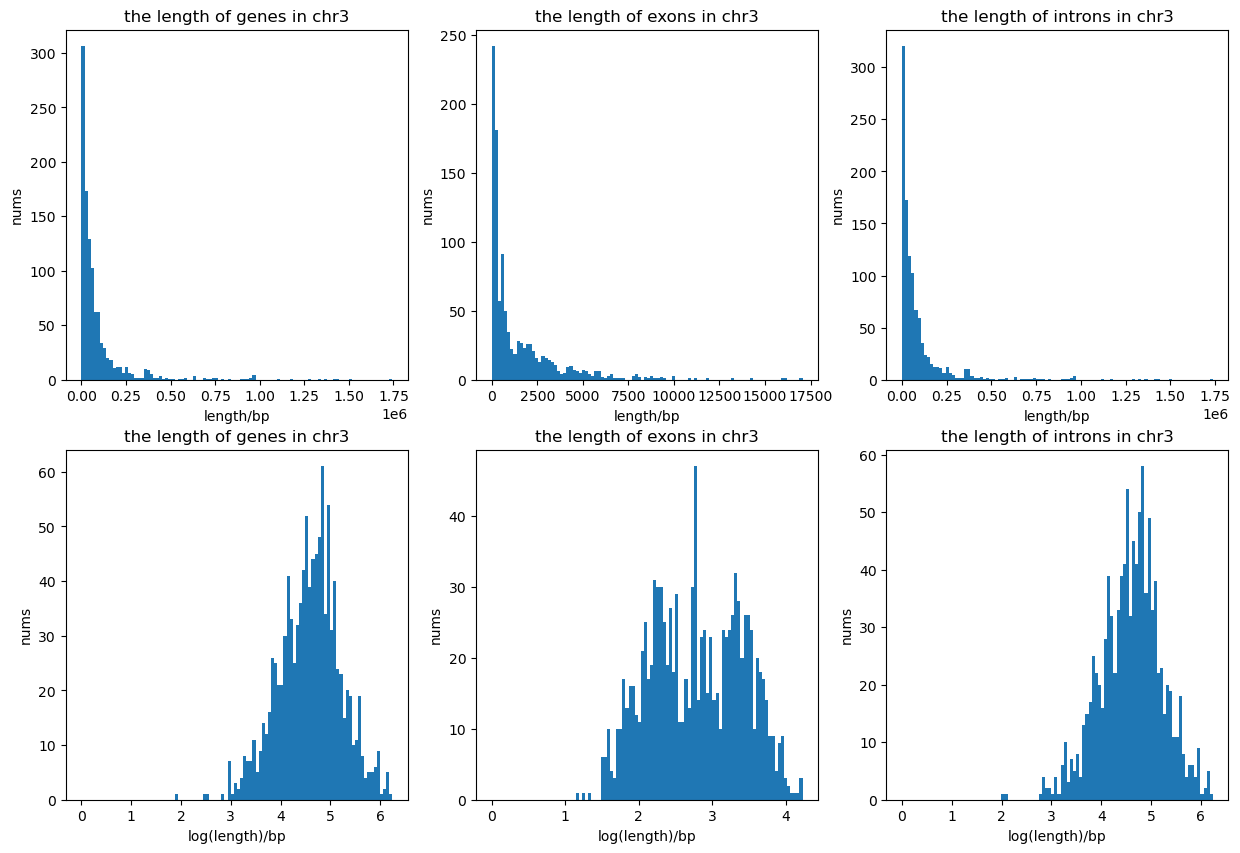

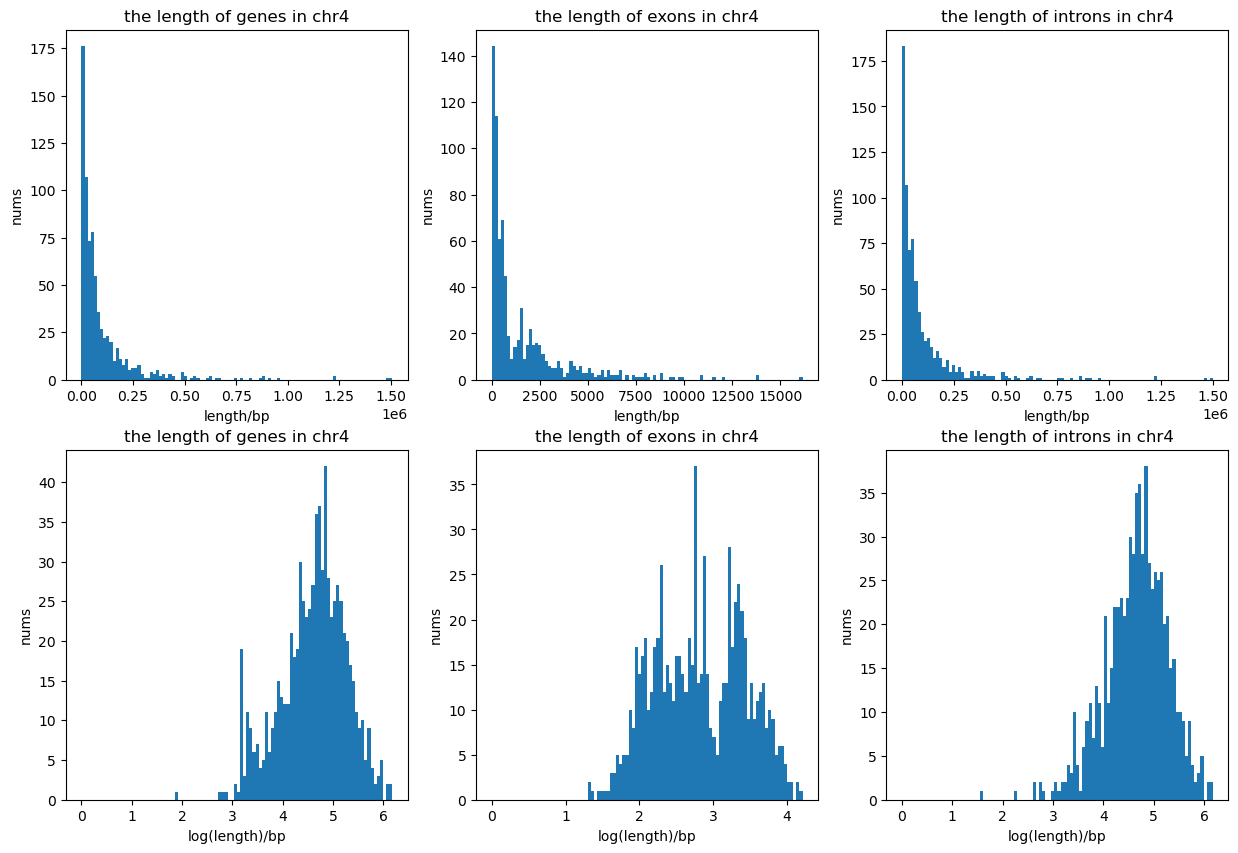

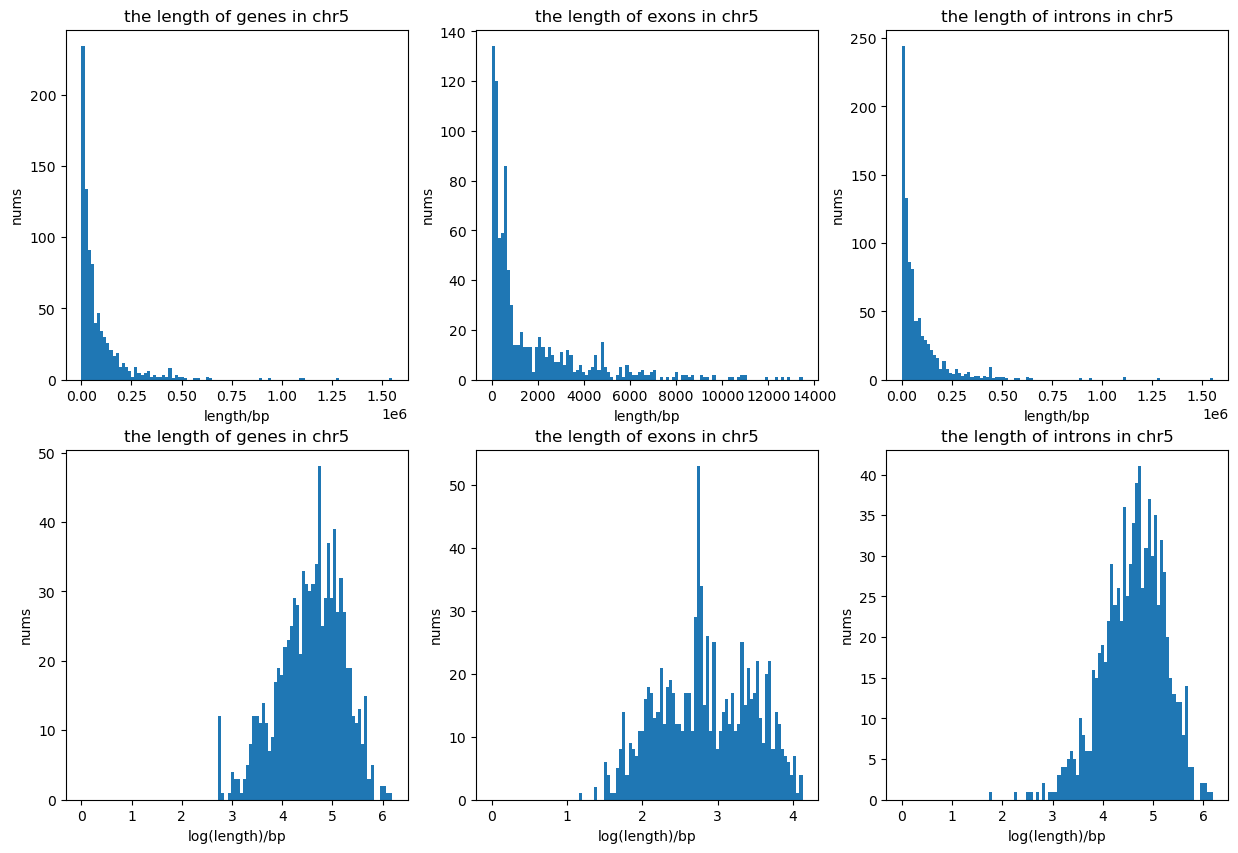

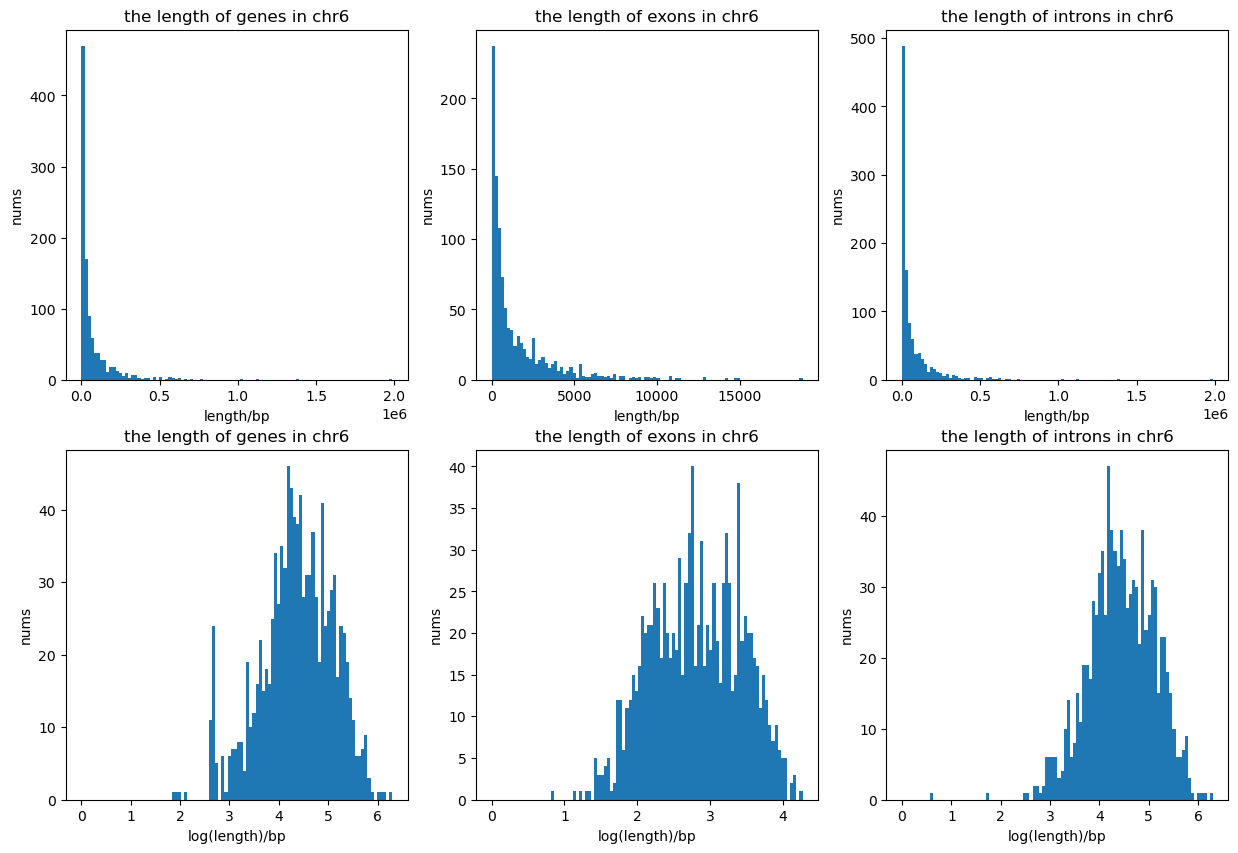

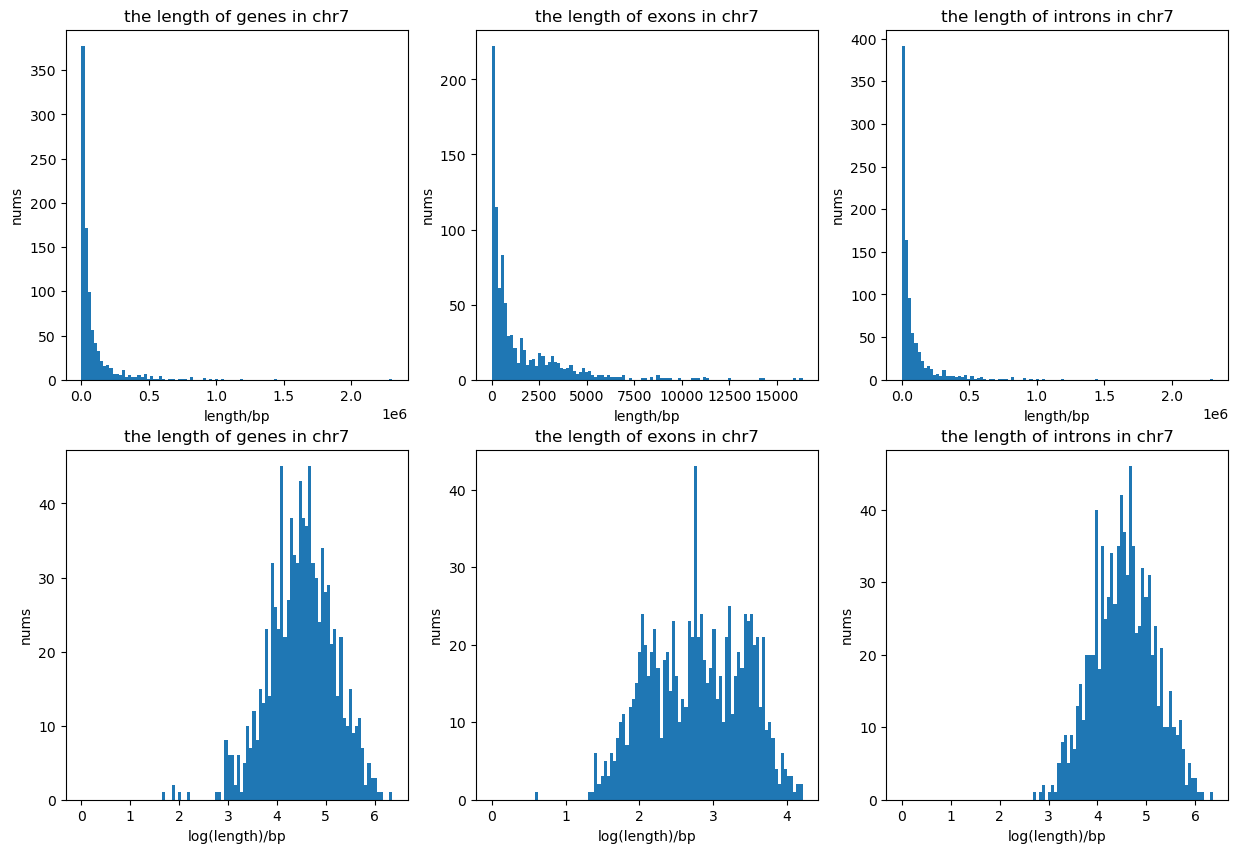

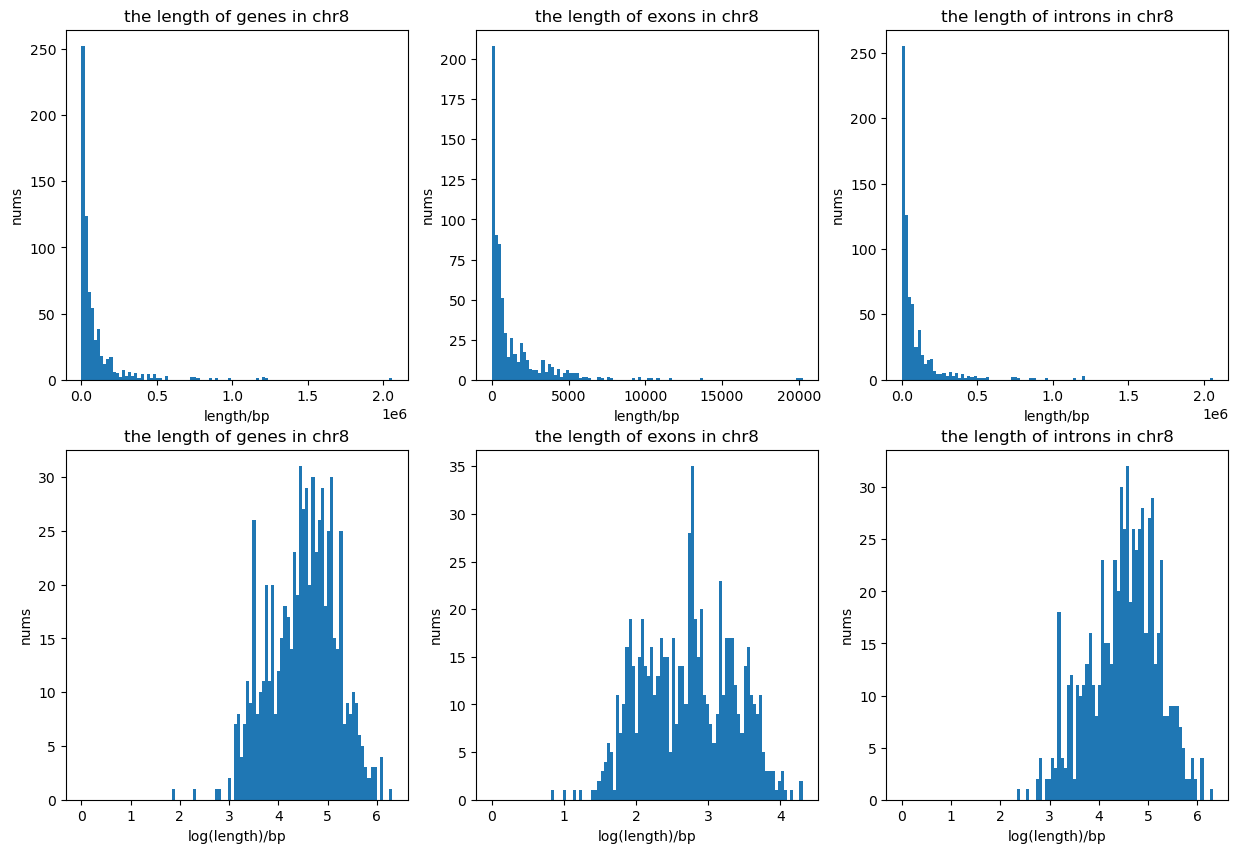

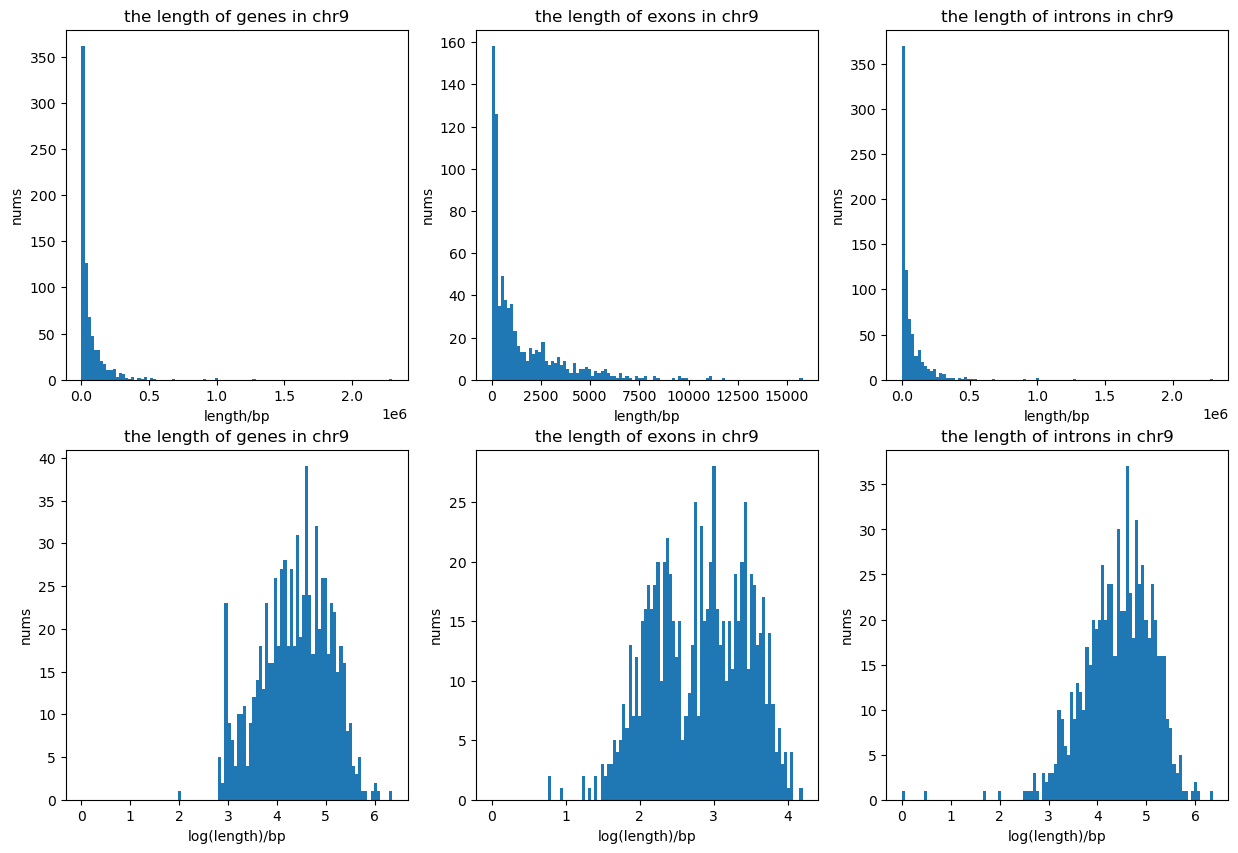

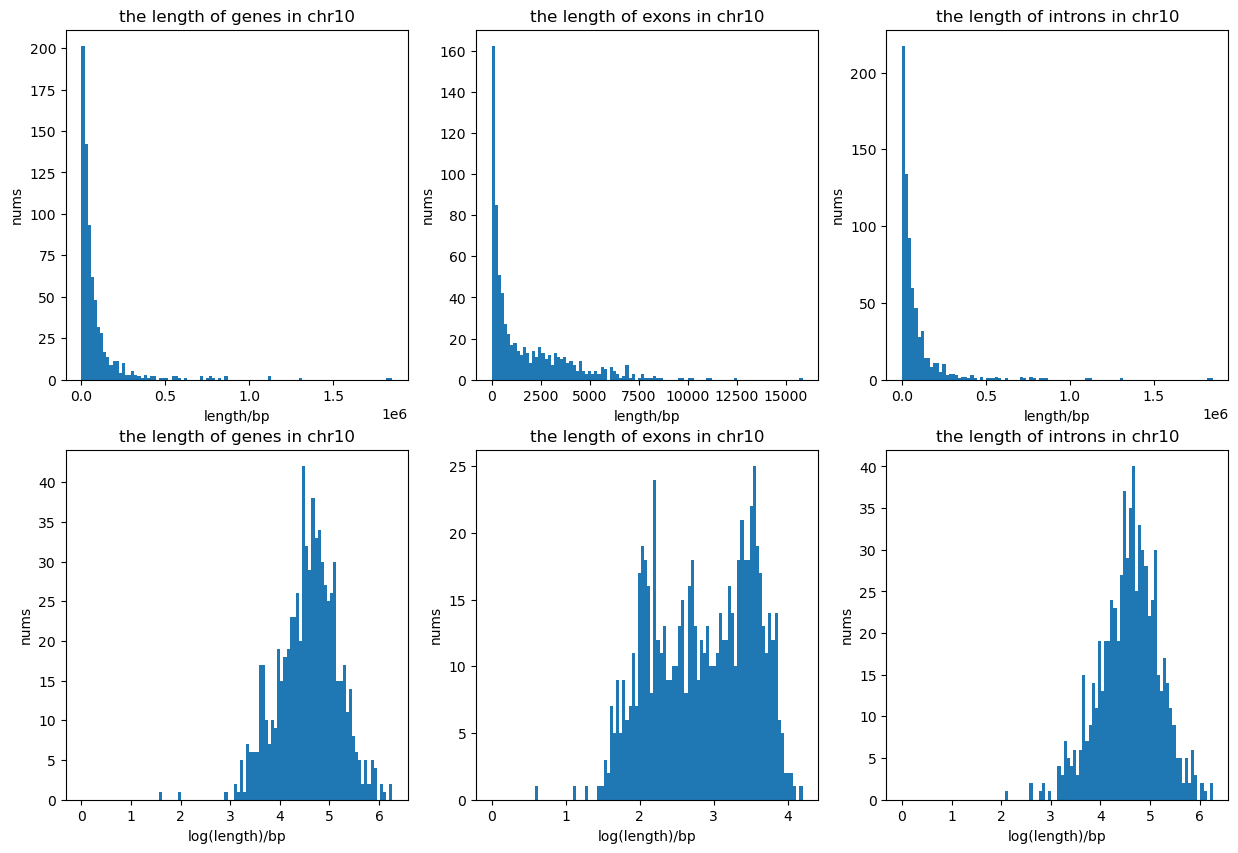

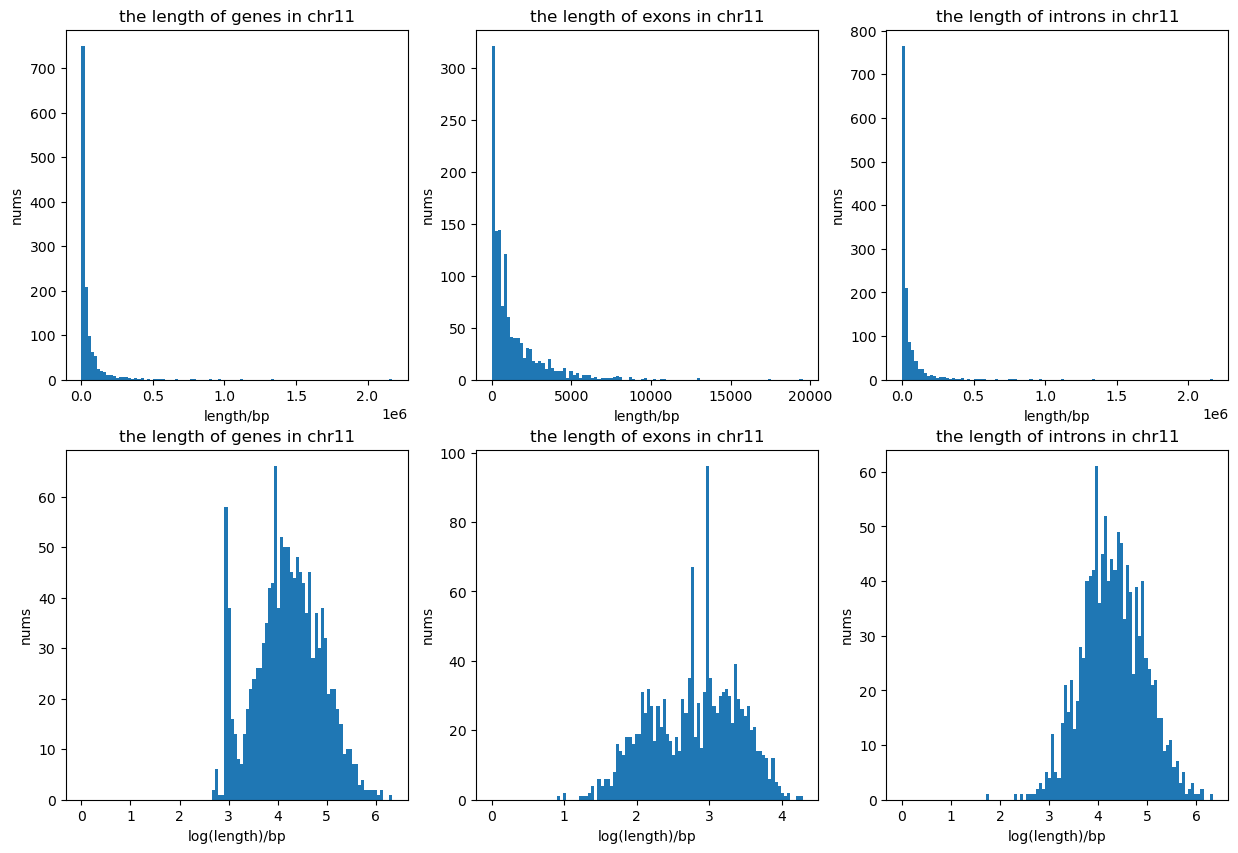

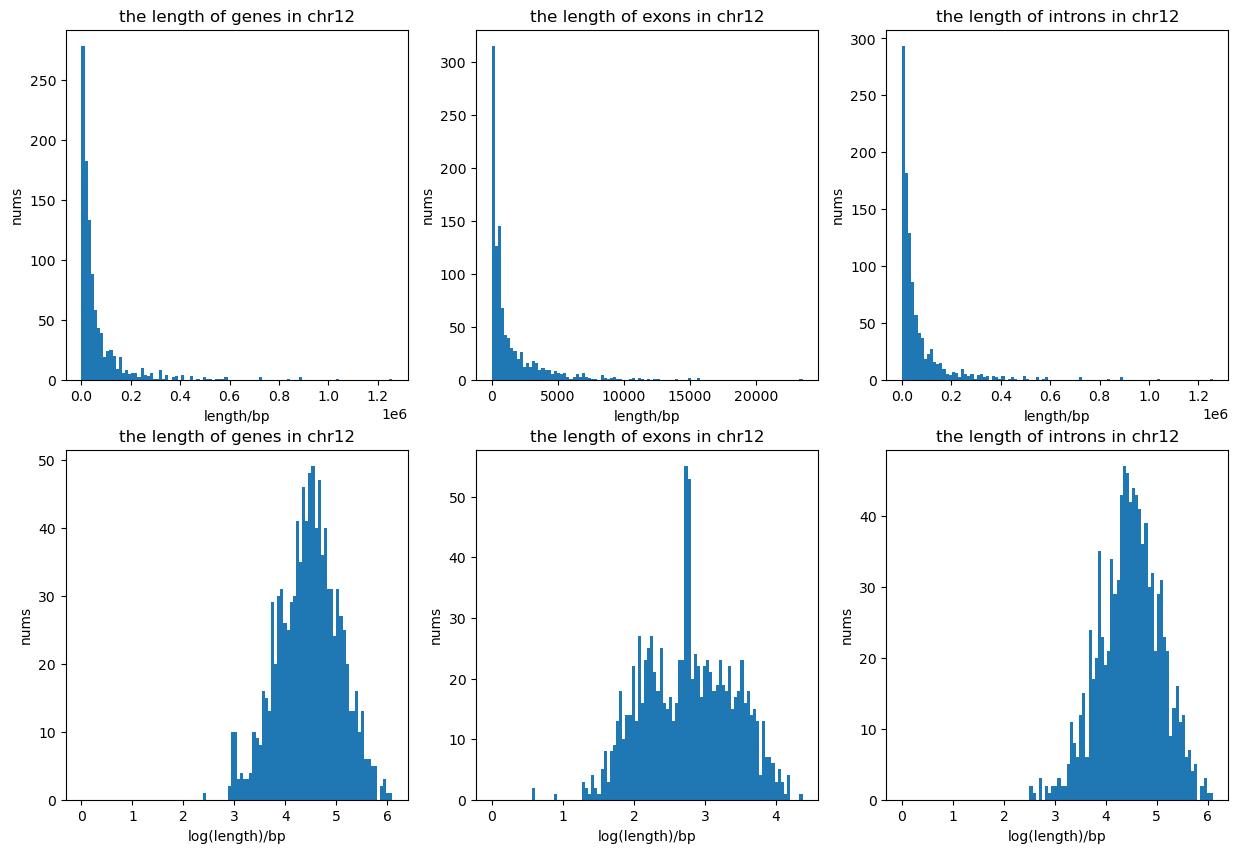

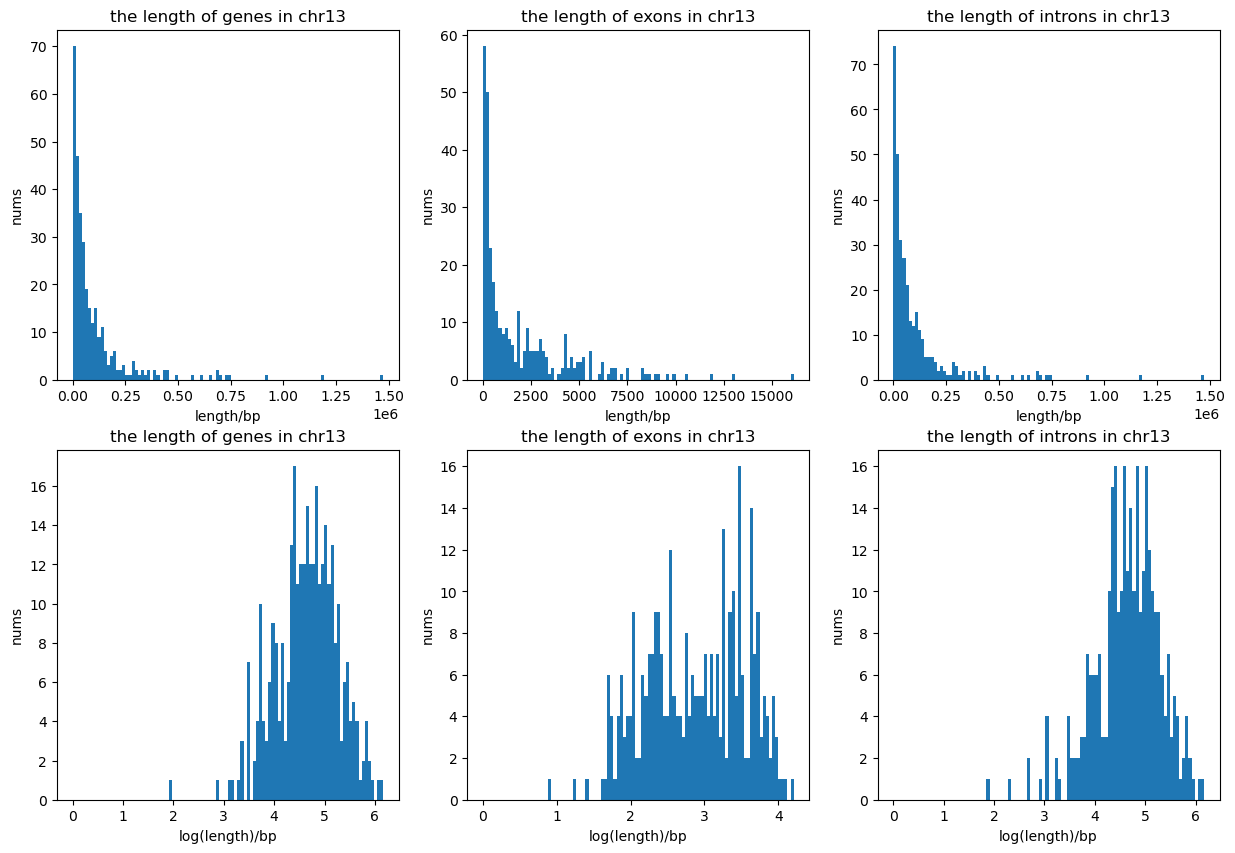

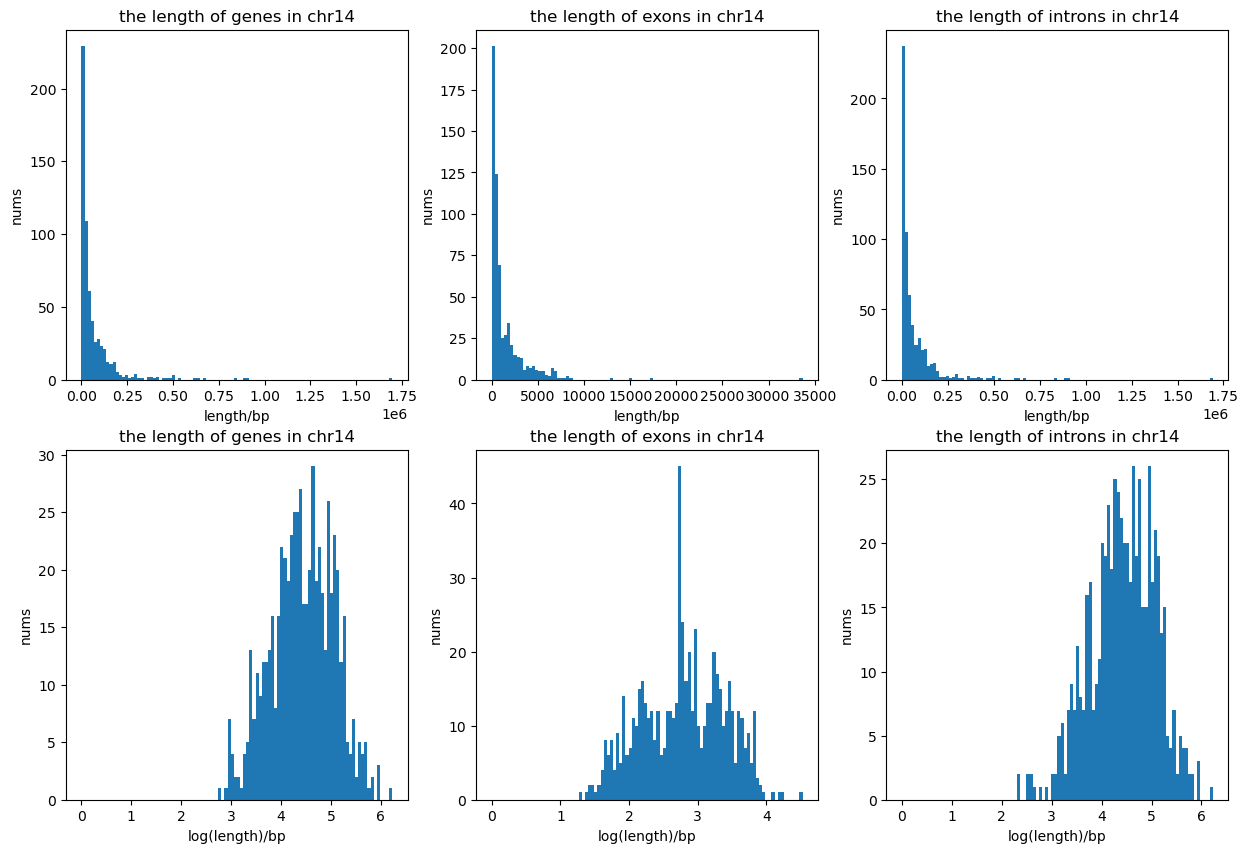

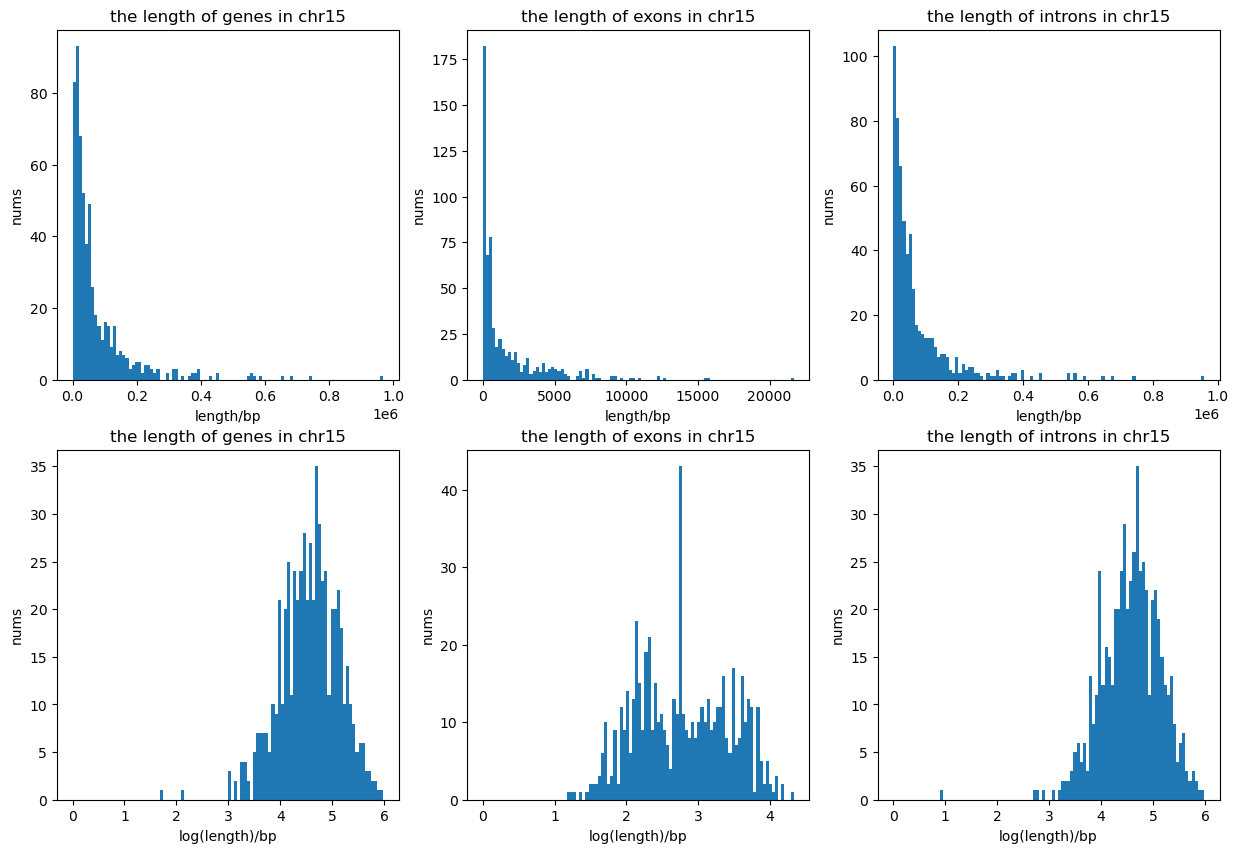

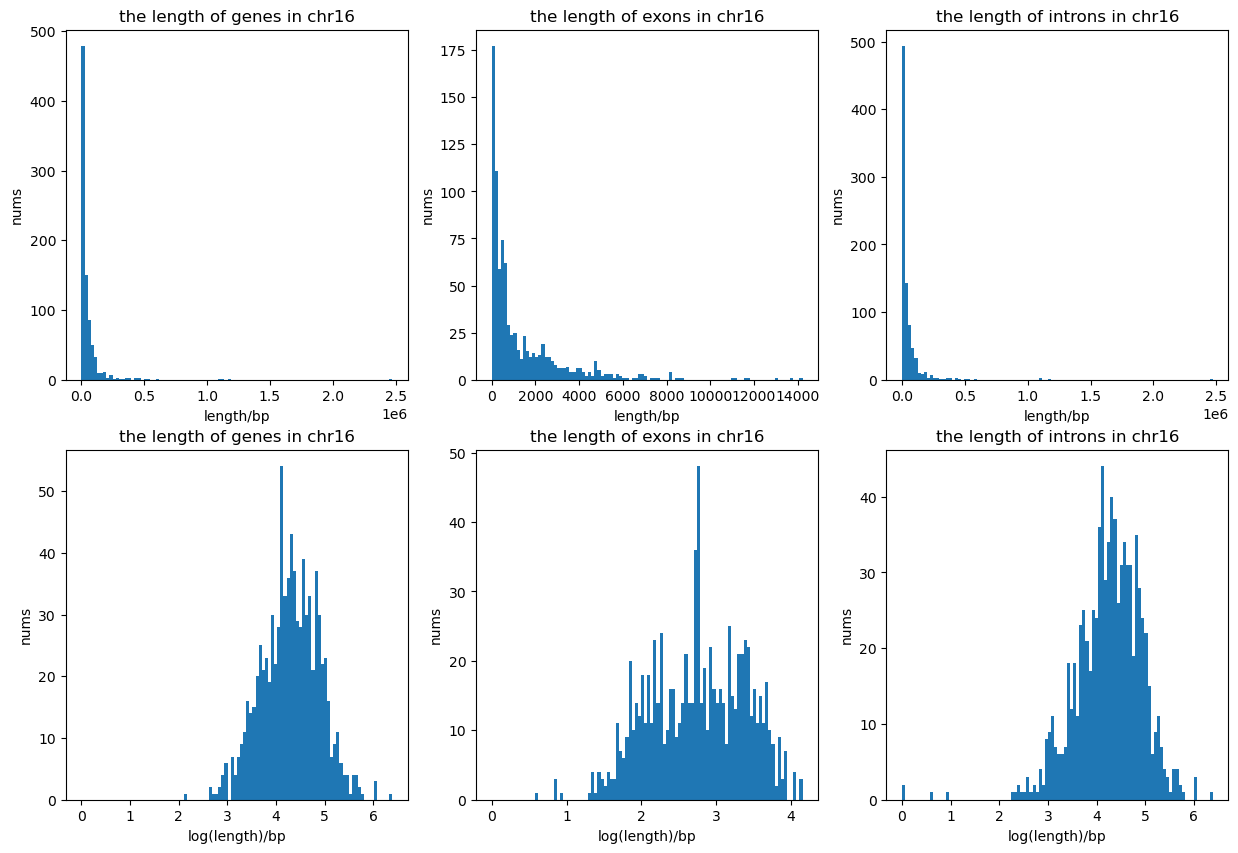

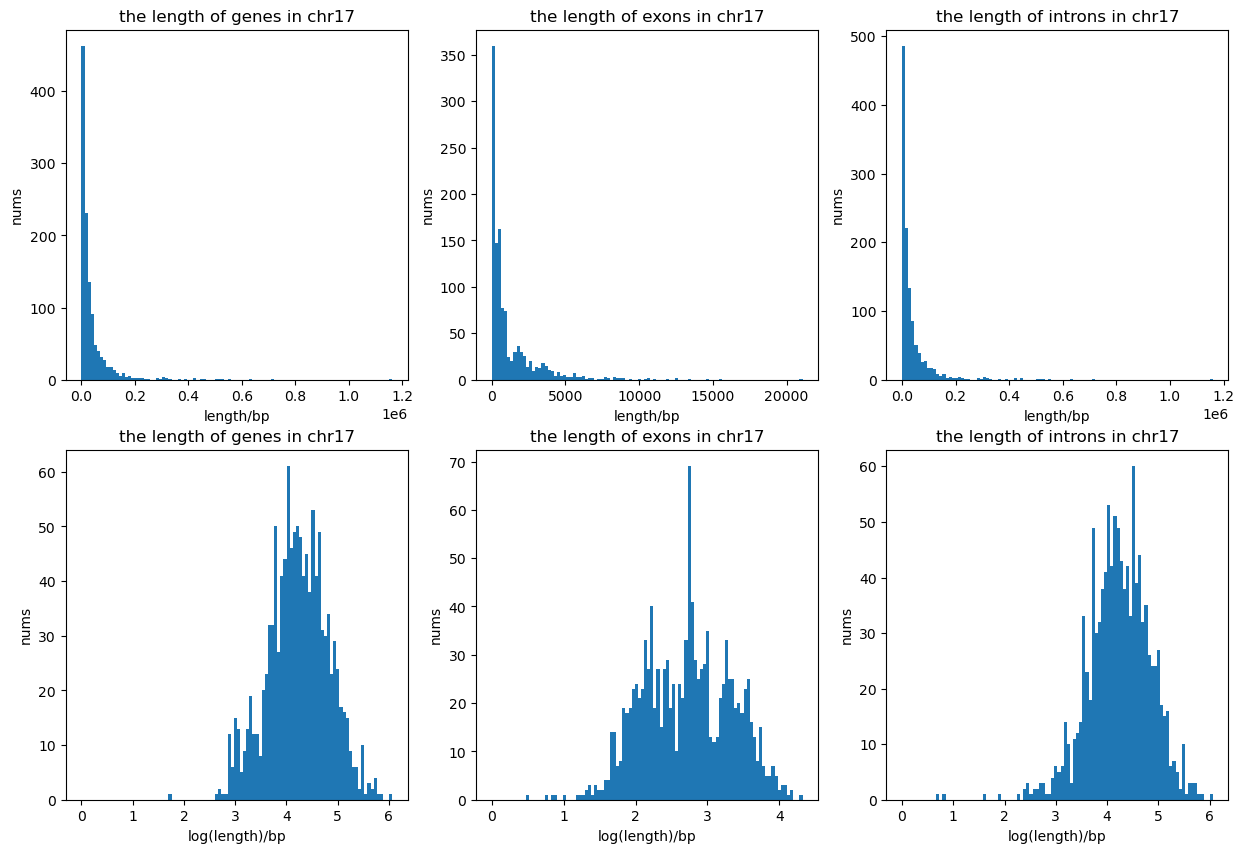

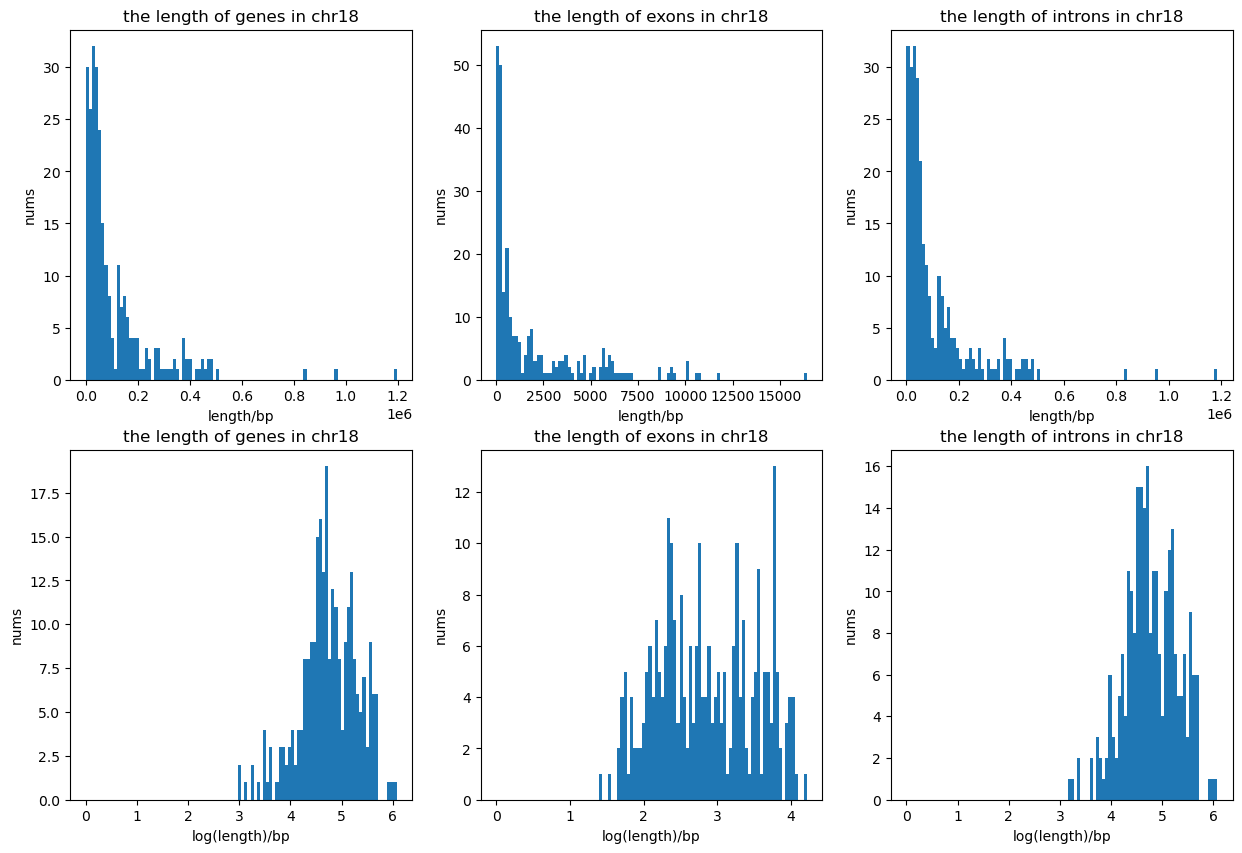

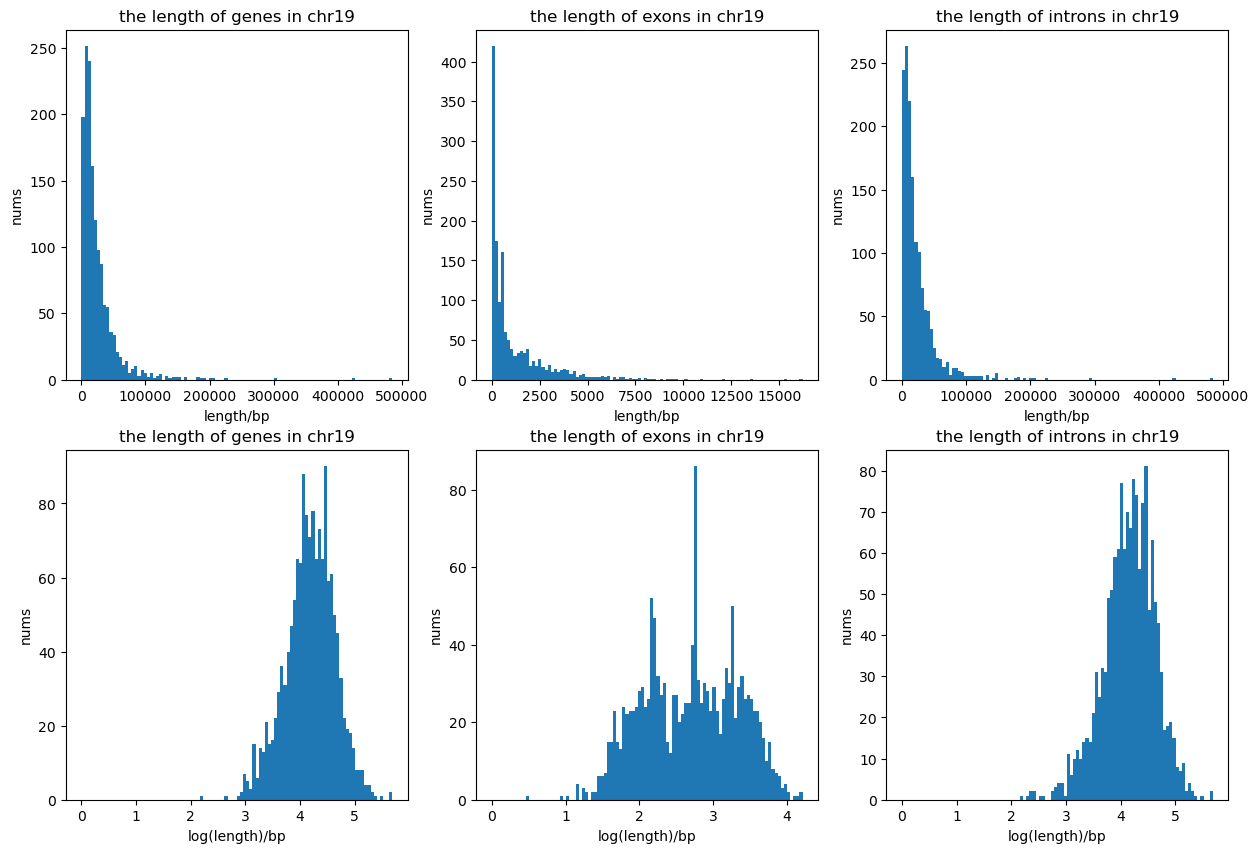

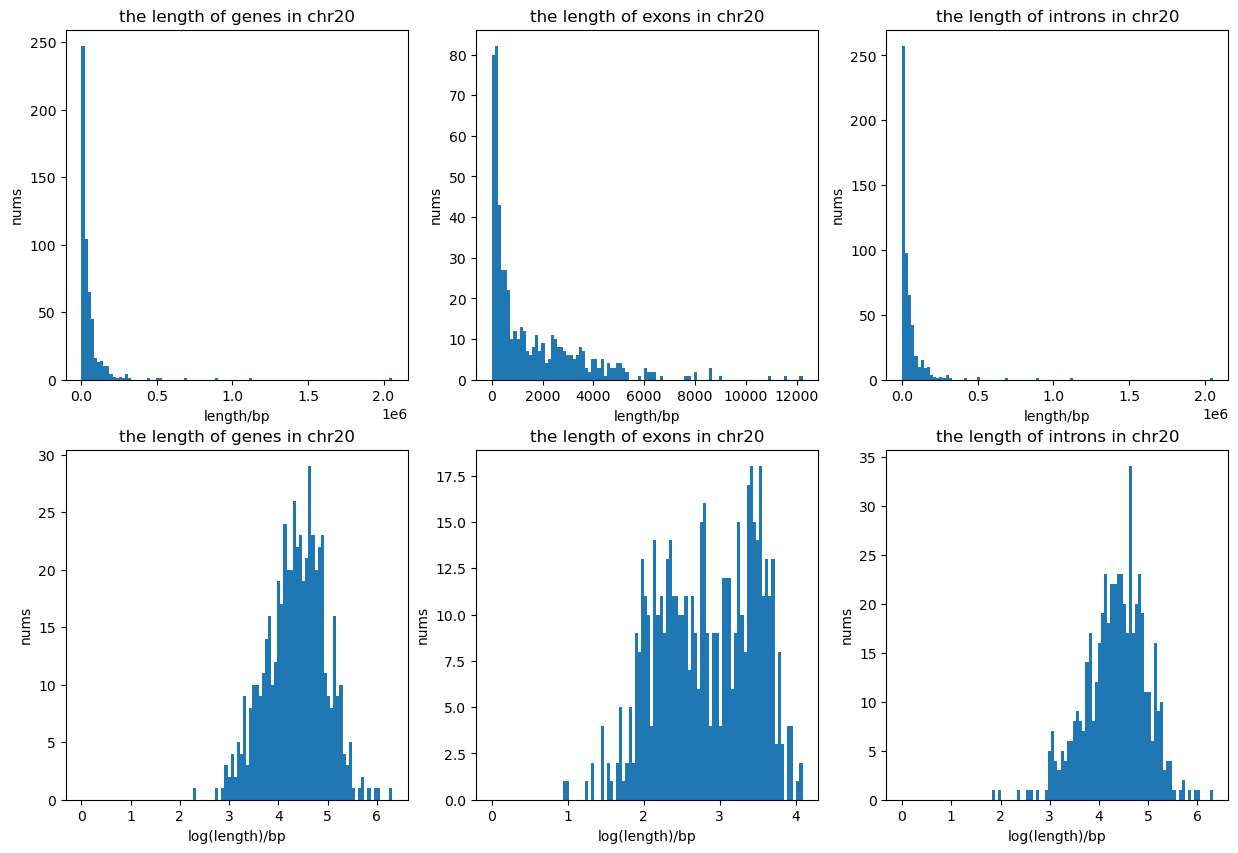

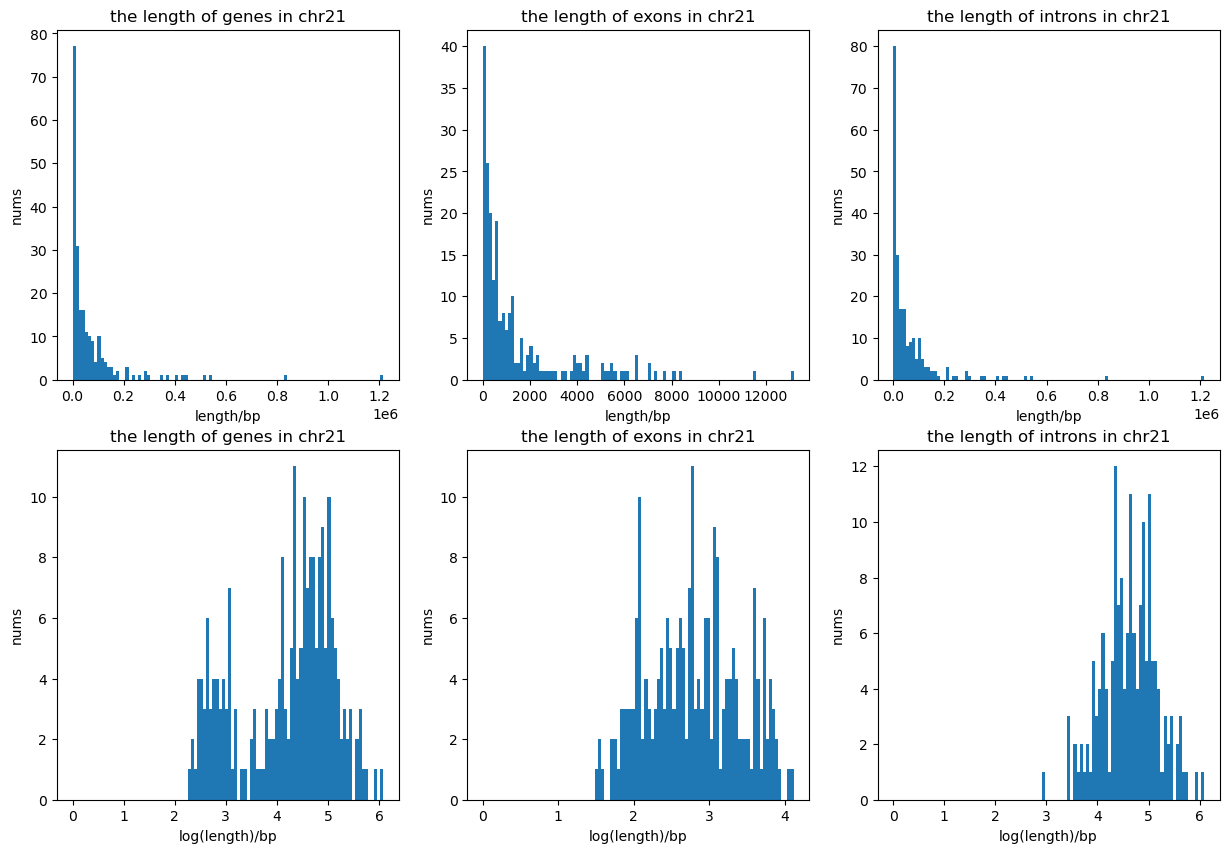

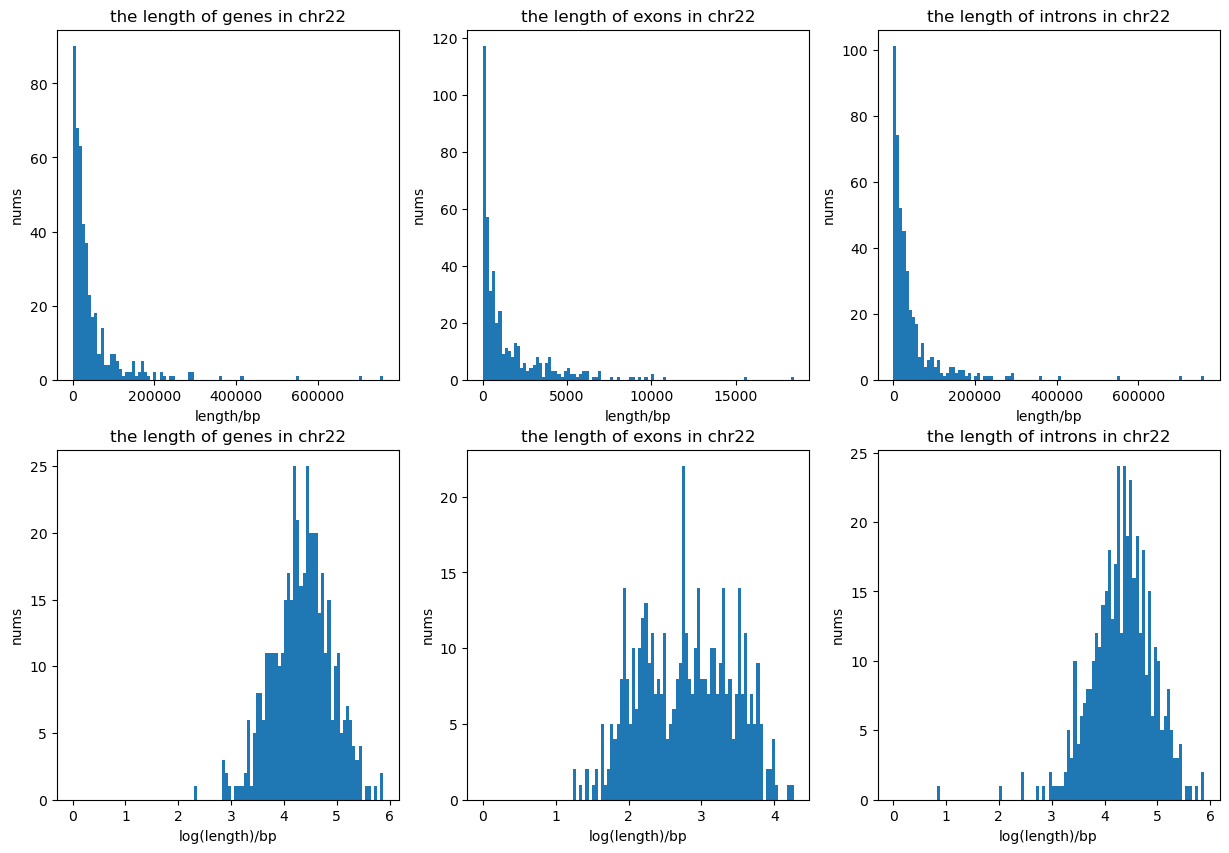

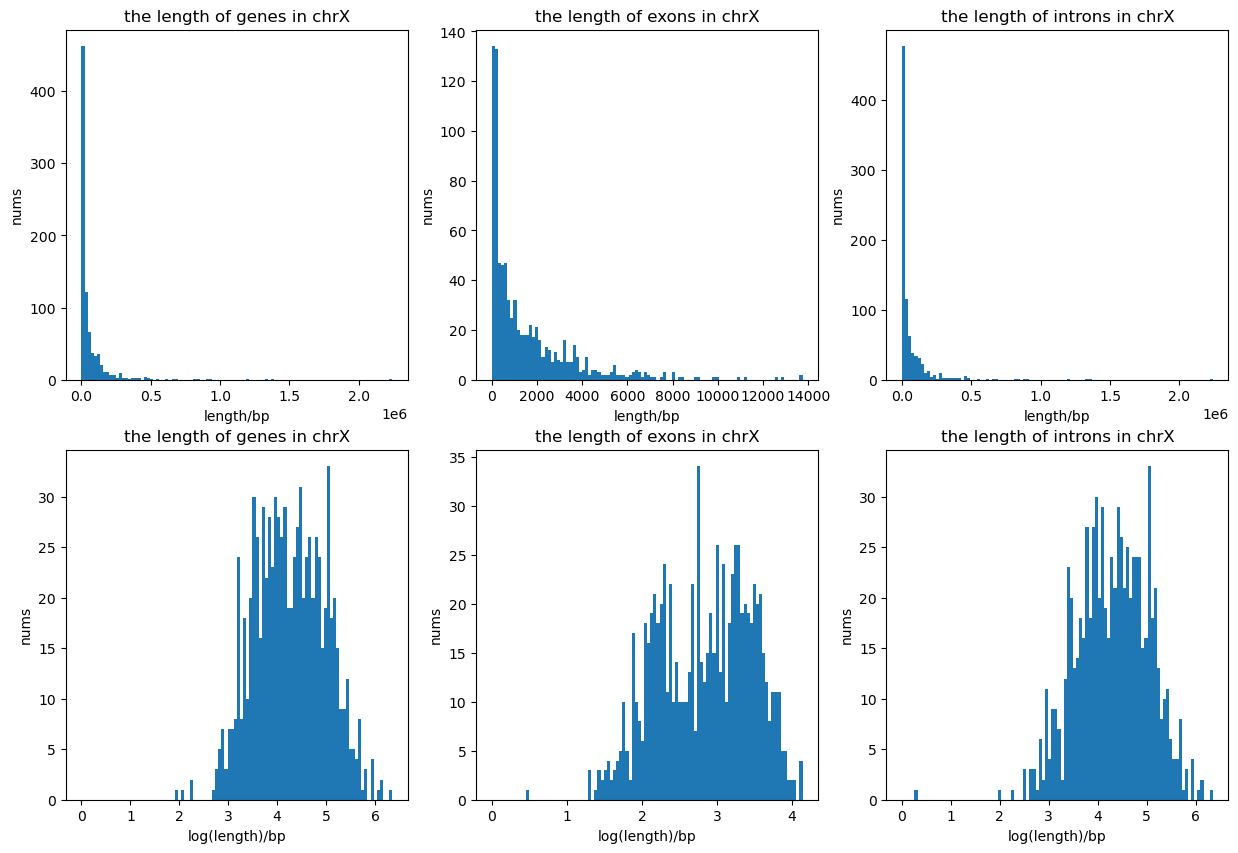

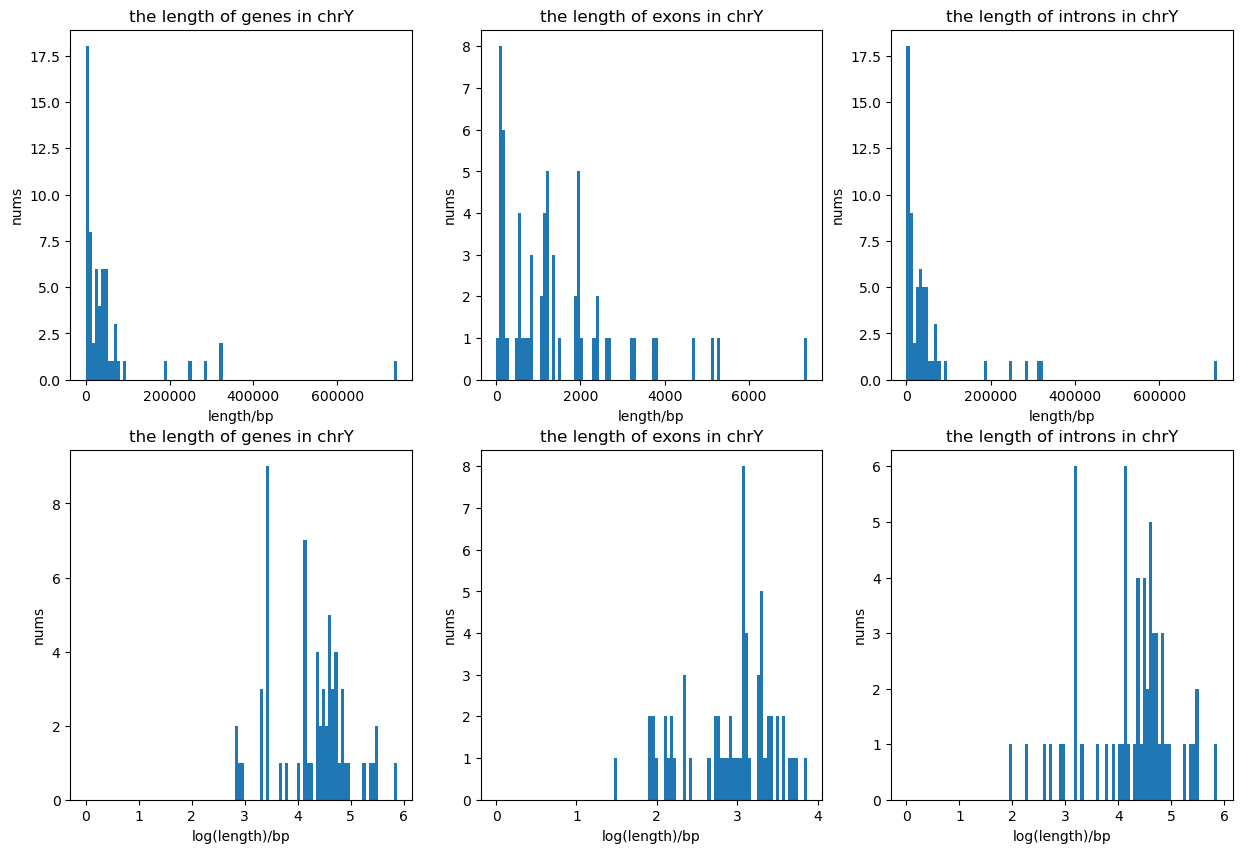

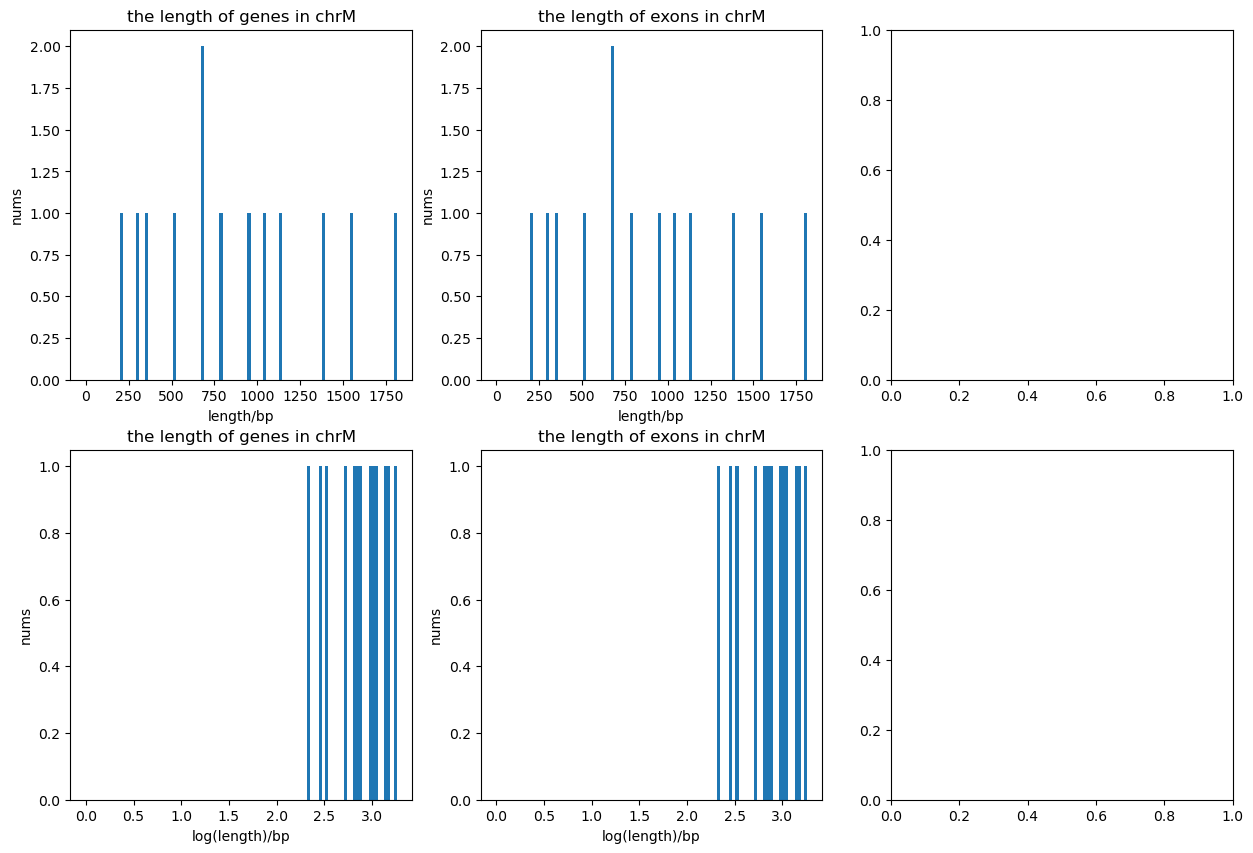

In [9]:
from cmath import inf
# median mean max min
gene_stat = [] 
exon_stat = []
intron_stat = []


for i in range(len(chr_num)):
    # 依次读取每个染色体的数据
    genes_len = np.array(chr_genes_len[i])
    exons_len = np.array(chr_exons_len[i])
    introns_len = np.array(chr_introns_len[i])
    
    # 计算每个染色体的统计数据
    gene_stat.append([np.median(genes_len), np.mean(genes_len), np.max(genes_len), np.min(genes_len)])
    exon_stat.append([np.median(exons_len), np.mean(exons_len), np.max(exons_len), np.min(exons_len)])
    intron_stat.append([np.median(introns_len), np.mean(introns_len), np.max(introns_len), np.min(introns_len)])
    
    # 取对数
    genes_len_log = np.log10(genes_len + 1e-12)
    exons_len_log = np.log10(exons_len + 1e-12)
    introns_len_log = np.log10(introns_len + 1e-12)
    
    # 画出长度的分布直方图
    plt.figure(i + 1, figsize=(15,10))

    plt.subplot(2,3,1)
    plt.title("the length of genes in " + chr_num[i])
    plt.xlabel("length/bp")
    plt.ylabel("nums")
    plt.hist(genes_len, 100, range=(0, genes_len.max()))

    plt.subplot(2,3,2)
    plt.title("the length of exons in " + chr_num[i])
    plt.xlabel("length/bp")
    plt.ylabel("nums")
    plt.hist(exons_len, 100, range=(0, exons_len.max()))

    plt.subplot(2,3,3)
    if introns_len.max() != 0:
        plt.title("the length of introns in " + chr_num[i])
        plt.xlabel("length/bp")
        plt.ylabel("nums")
        plt.hist(introns_len, 100, range=(0, introns_len.max()))
    
    plt.subplot(2,3,4)
    plt.title("the length of genes in " + chr_num[i])
    plt.xlabel("log(length)/bp")
    plt.ylabel("nums")
    plt.hist(genes_len_log, 100, range=(0, genes_len_log.max()))

    plt.subplot(2,3,5)
    plt.title("the length of exons in " + chr_num[i])
    plt.xlabel("log(length)/bp")
    plt.ylabel("nums")
    plt.hist(exons_len_log, 100, range=(0, exons_len_log.max()))
    
    plt.subplot(2,3,6)
    if introns_len.max() != 0:
        plt.title("the length of introns in " + chr_num[i])
        plt.xlabel("log(length)/bp")
        plt.ylabel("nums")
        plt.hist(introns_len_log, 100, range=(0, introns_len_log.max()))

    plt.savefig(os.path.join(figure_folder, chr_num[i]+".png"))
    plt.show()

gene_stat = np.array(gene_stat)
exon_stat = np.array(exon_stat)
intron_stat = np.array(intron_stat)

### 5.保存数据文件

In [10]:
gene_stat_df = pd.DataFrame(gene_stat)
gene_stat_df.columns = ["median", "mean", "max", "min"]
gene_stat_df.index = chr_num
gene_stat_df.to_csv(os.path.join(statistics_folder, "gene_stat.csv"))

exon_stat_df = pd.DataFrame(exon_stat)
exon_stat_df.columns = ["median", "mean", "max", "min"]
exon_stat_df.index = chr_num
exon_stat_df.to_csv(os.path.join(statistics_folder, "exon_stat.csv"))

intron_stat_df = pd.DataFrame(intron_stat)
intron_stat_df.columns = ["median", "mean", "max", "min"]
intron_stat_df.index = chr_num
intron_stat_df.to_csv(os.path.join(statistics_folder, "intron_stat.csv"))

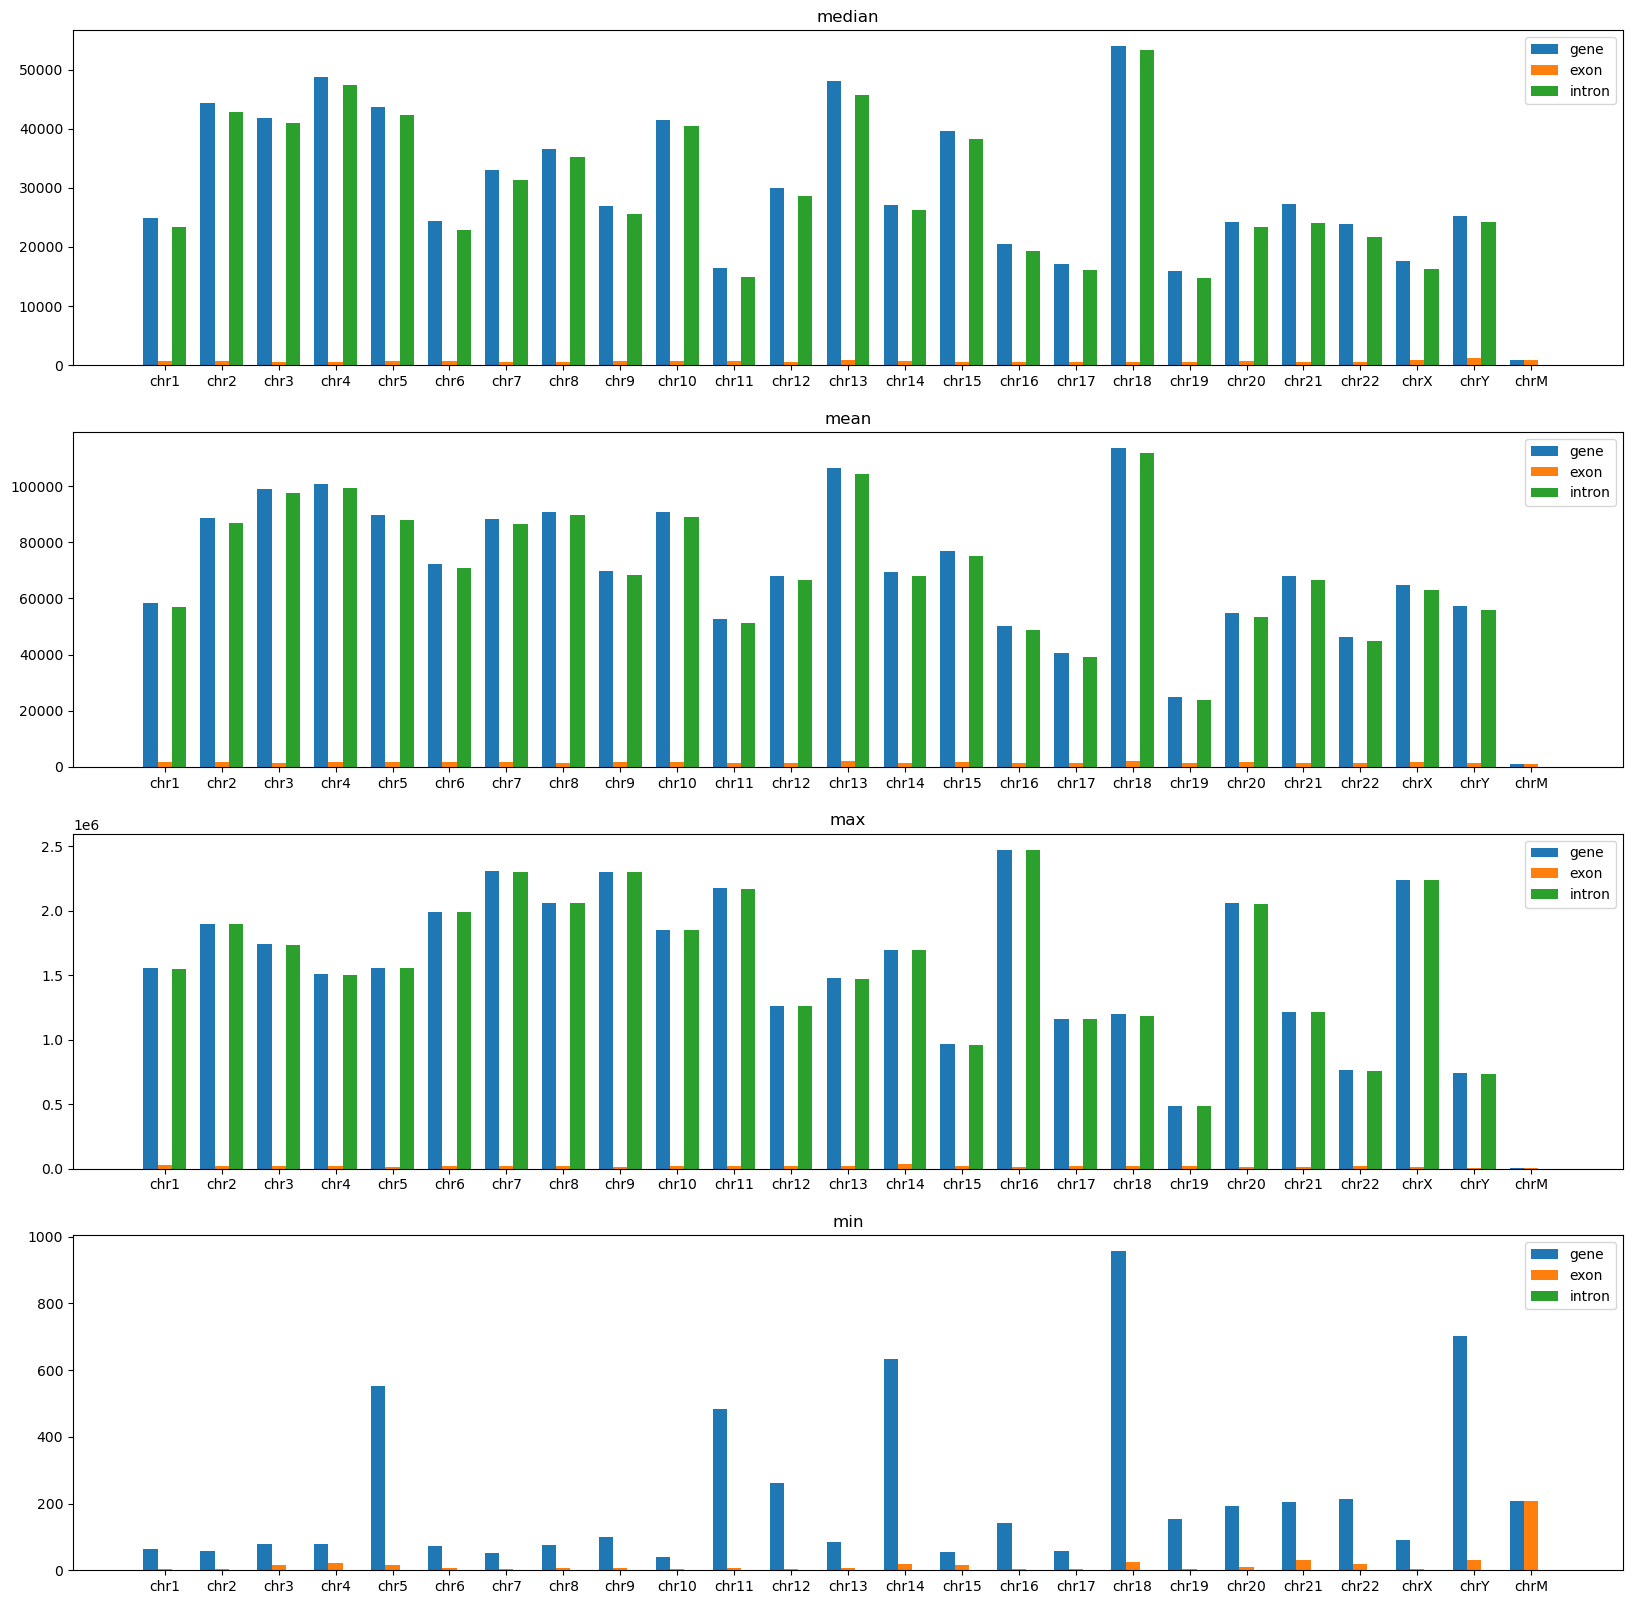

In [11]:
plt.figure(figsize=(20,20))
x = np.arange(len(chr_num))
width = 0.25

plt.subplot(4,1,1)
plt.bar(x - width, gene_stat[:, 0], width, label='gene')
plt.bar(x, exon_stat[:, 0], width, label='exon')
plt.bar(x + width, intron_stat[:, 0], width, label='intron')
plt.xticks(x, labels=chr_num)
plt.title("median")
plt.legend()

plt.subplot(4,1,2)
plt.bar(x - width, gene_stat[:, 1], width, label='gene')
plt.bar(x, exon_stat[:, 1], width, label='exon')
plt.bar(x + width, intron_stat[:, 1], width, label='intron')
plt.xticks(x, labels=chr_num)
plt.title("mean")
plt.legend()

plt.subplot(4,1,3)
plt.bar(x - width, gene_stat[:, 2], width, label='gene')
plt.bar(x, exon_stat[:, 2], width, label='exon')
plt.bar(x + width, intron_stat[:, 2], width, label='intron')
plt.xticks(x, labels=chr_num)
plt.title("max")
plt.legend()

plt.subplot(4,1,4)
plt.bar(x - width, gene_stat[:, 3], width, label='gene')
plt.bar(x, exon_stat[:, 3], width, label='exon')
plt.bar(x + width, intron_stat[:, 3], width, label='intron')
plt.xticks(x, labels=chr_num)
plt.title("min")
plt.legend()

plt.savefig(os.path.join(figure_folder, "fig_stat.png"))
plt.show()

In [12]:
print(sum(protein_coding_genes.values()))

20017
